In [1]:
#in this script we are taking our ATO_T6 data and adding additional annotations using celltypist to aid in integration with other datasets
import scanpy as sc
import anndata as ad
import pandas as pd

In [2]:
import celltypist
from celltypist import models

In [3]:
adata = sc.read_csv(filename="/g/data/yr31/hb1618/iPSC_project/datasets/g2g_ipsc/ATO_T06/ATO_T06_countdata.tsv", delimiter='\t', first_column_names=True )

In [4]:
metadata = pd.read_csv("/g/data/yr31/hb1618/iPSC_project/datasets/g2g_ipsc/ATO_T06/ATO_T06_metadata.csv", index_col=0) #index_col sets first col to be rownames

In [5]:
adata.obs = adata.obs.join(metadata)

In [6]:
print(adata)

AnnData object with n_obs × n_vars = 6513 × 16987
    obs: 'sanger_sample_id', 'percent_total_human_UMI', 'percent_total_mito_UMI', 'human_cells', 'total_UMI_count_across_genes', 'n_genes_expressed', 'souporcell_doublet_prediction', 'souporcell_doublet_logprob', 'batch', 'sample', 'time_id', 'scrublet_doublet_scores', 'scrublet_predicted_doublets', 'new_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'


In [7]:
adata.layers["counts"] = adata.X.copy() #store the raw count data

In [8]:
#normalising gene expression counts before celltypist run
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum = 10000)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000)

sc.tl.pca(adata)

sc.pp.neighbors(adata)

sc.tl.umap(adata)

# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)
#note that in G2G lab notebook they run CellTypist using highly variable genes, but CellTypist documentation recommends all genes
#we will run with all genes

/g/data/yr31/hb1618/iPSC_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
predictions = celltypist.annotate(adata, model = "Pan_Fetal_Human.pkl", majority_voting = True)
predictions_high = celltypist.annotate(adata, model = "Immune_All_High.pkl", majority_voting = True)
predictions_low = celltypist.annotate(adata, model = "Immune_All_Low.pkl", majority_voting = True)
predictions_thymus = celltypist.annotate(adata, model = "Developing_Human_Thymus.pkl", majority_voting = True)

🔬 Input data has 6513 cells and 16987 genes
🔗 Matching reference genes in the model
🧬 5398 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 6513 cells and 16987 genes
🔗 Matching reference genes in the model
🧬 4970 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 6513 cells and 16987 genes
🔗 Matching reference genes in the model
🧬 4970 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood grap

In [10]:
adata.obs['celltypist_panfetal_predictions'] =  predictions.predicted_labels['majority_voting']
adata.obs['celltypist_high_predictions'] = predictions_high.predicted_labels['majority_voting']
adata.obs['celltypist_low_predictions'] = predictions_low.predicted_labels['majority_voting']
adata.obs['celltypist_thymus_predictions'] = predictions_thymus.predicted_labels['majority_voting']

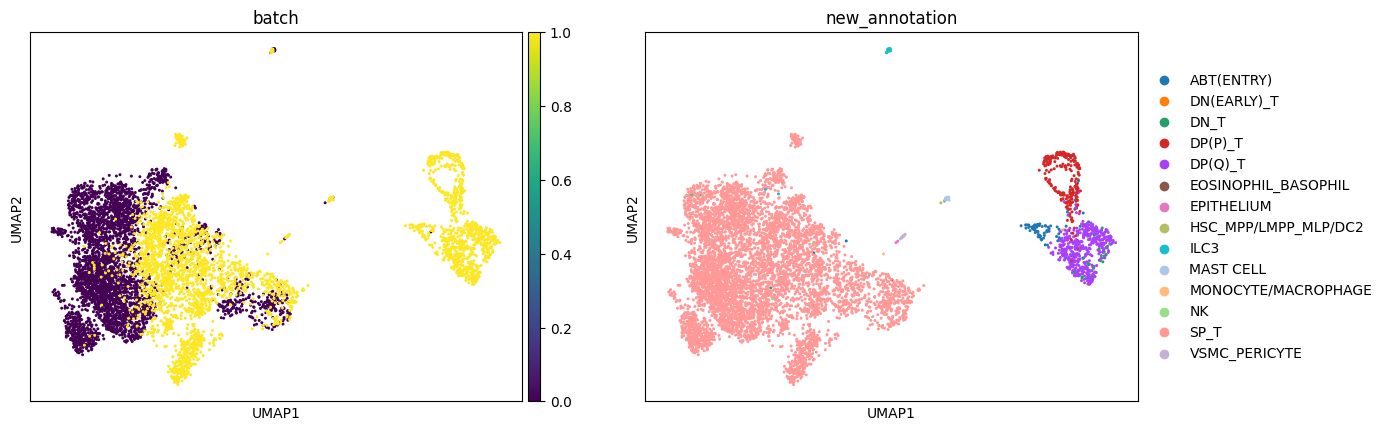

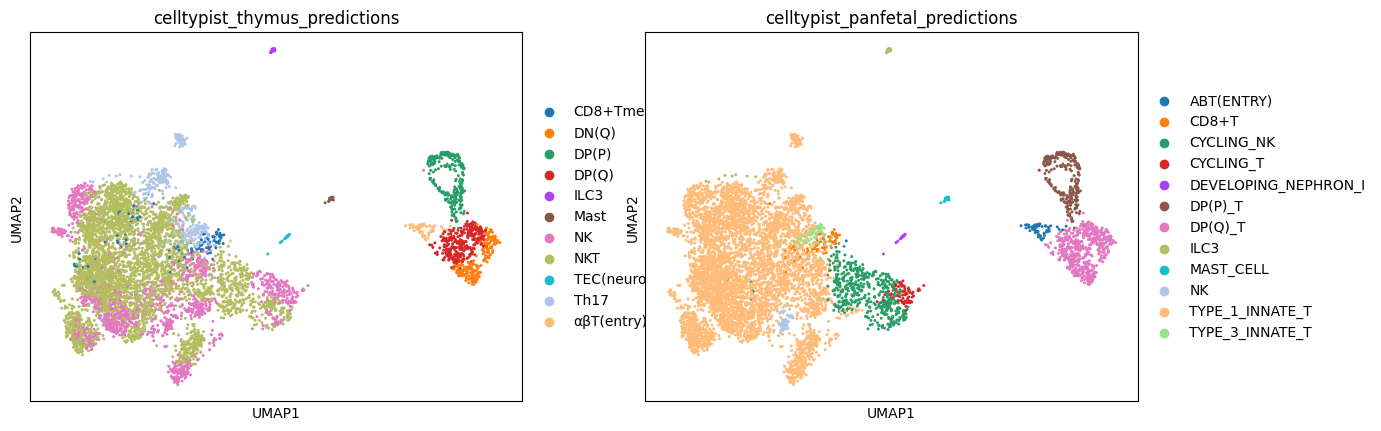

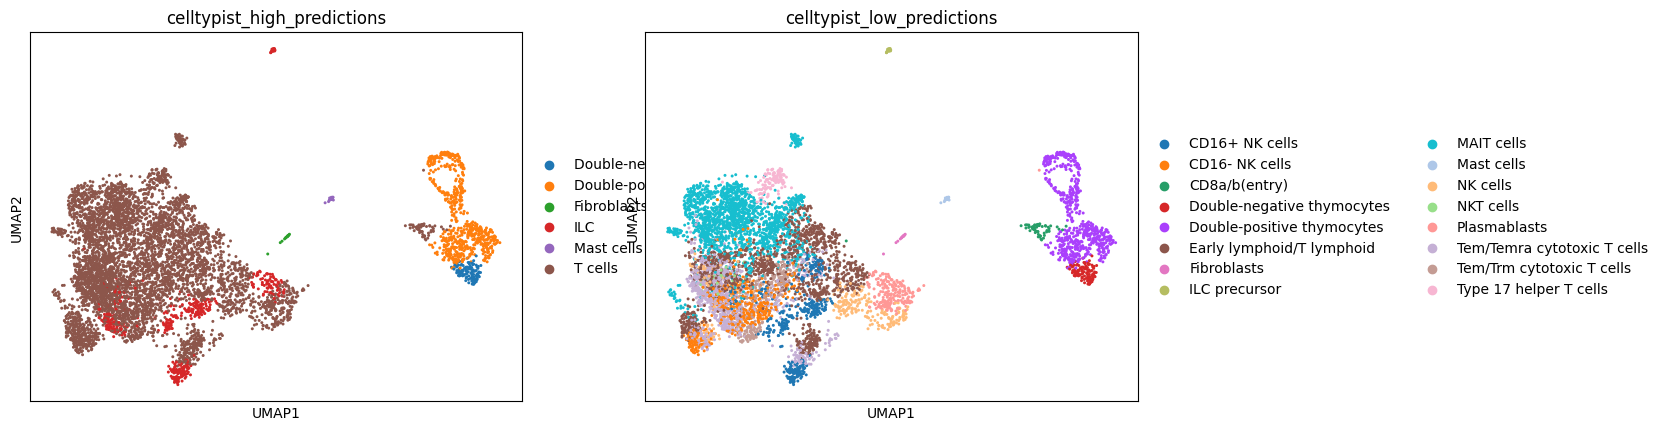

In [12]:
sc.pl.umap(adata,color=['batch', 'new_annotation'], legend_loc="right margin")
sc.pl.umap(adata,color=['celltypist_thymus_predictions', 'celltypist_panfetal_predictions'], legend_loc="right margin")
sc.pl.umap(adata,color=['celltypist_high_predictions', 'celltypist_low_predictions'], legend_loc="right margin") #low granularity and high granularity

In [13]:
#exporting metadata
# Save the metadata, containing our new celltypist predictions, to the existing metadata file
adata.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/g2g_ipsc/ATO_T06/ATO_T06_metadata.csv")